# 05. 적대적 교란 신경망 (GAN)
> 두 네트워크가 경쟁하며 성장하는 GAN에 대해 배워봅시다.

- toc: true 
- badges: true
- comments: true
- categories: [Day 8]
- permalink: /gan
- exec: colab

### 1. 비유로 GAN 이해하기
GAN(적대적 교란 신경망)이 무엇인지 이해하는 가장 쉬운 방법은 우리에게 익숙한 것에 비유해보는 것입니다. 가령 고객으로부터 와인을 사들이는 가게를 가정해봅시다.

![](https://raw.githubusercontent.com/KerasKorea/KEKOxTutorial/master/media/89_0.png)

공정한 거래가 오가면 모두 평화롭지만, 돈을 벌기 위해 가짜 와인을 파는 사악한 고객들도 있습니다. 이 경우 가게 주인은 가짜 와인과 진품 와인을 구분할 수 있어야 합니다.

![](https://raw.githubusercontent.com/KerasKorea/KEKOxTutorial/master/media/89_1.png)

여러분은 위조 와인을 팔려는 가짜 와인 위조범이 처음에는 많은 실수를 할지도 모른다고 상상할 수 있습니다. 그렇다면 가게 주인은 그 와인이 진짜가 아니라는 것을 쉽게 알아낼 것입니다.
<br><br>

이러한 실패로 인해, 가짜 와인 위조범은 진품 와인처럼 만들기 위해서 다른 기술을 계속 시도할 것이고 일부는 결국 성공하게 될 것입니다. 이제 가짜 와인 위조범은 자신의 특정 기술이 상점 주인이 알아차릴 수 있는 수준을 넘어갔다는 것을 알았고, 이 기술을 바탕으로 가짜 와인을 더 발전시키기 시작할 수 있습니다.
<br><br>

동시에, 가게 주인은 다른 가게 주인이나 와인 전문가들로부터 그녀가 가지고 있는 와인의 일부가 진짜가 아니라는 피드백을 받을 것입니다. 이것은 가게 주인이 진짜 와인과 가짜 와인을 판단하는 방법을 개선해야 한다는 것을 의미합니다.
<br><br>

따라서 가짜 와인 위조범의 목표는 진품과 구별이 안 되는 와인을 만드는 것이고, 가게 주인의 목표는 와인이 진짜인지 아닌지 정확하게 알아내는 것입니다.
<br><br>

**위조범과 위조를 구분해내려는 자의 경쟁이 GAN의 기본 아이디어 입니다.**
<br><br>


### 2. GAN의 구성요소

위의 예제를 이용하여, 우리는 GAN의 아키텍처를 그려볼 수 있습니다.

![](https://raw.githubusercontent.com/KerasKorea/KEKOxTutorial/master/media/89_2.png)

여기에 GANs의 주요 구성요소가 있습니다: Generator(생성자)와 Discriminator(식별자) 입니다.
<br><br>

위의 예제에서 와인이 진짜인지 가짜인지 식별하는 가게 주인이 바로 Discriminator이고, 주로 어떤 이미지가 진짜인지 아닌지에 대한 확률을 주는 Convolutional Neural Networks (GANs은 주로 이미지 쪽에서 많이 쓰이기 때문에)를 사용합니다.
<br><br>

가짜 와인 위조범은 Generator이고, 이 네트워크 역시 일반적으로 Convolutional Neural Network를 사용합니다. (deconvolutional layer와 함께). 이 네트워크는 노이즈 벡터를 가져와서 이미지를 출력합니다. Generative 네트워크를 훈련할 때, Discriminator가 생성된 이미지를 실제 이미지와 구분하는 데 어려움을 겪도록 이미지에서 개선/변경 영역을 학습합니다.
<br><br>

Generative 네트워크는 실제 이미지와 비슷한 모습을 계속해서 생성하는 반면, Discriminative 네트워크는 실제 이미지와 가짜 이미지의 차이를 확인하려고 노력합니다. 궁극적인 목표는 실제 이미지와 구별할 수 없는 이미지를 생성할 수 있는 생성 네트워크를 갖는 것입니다.
<br><br>


<br>

### 3. GAN 구현해보기

원래는 사람 얼굴을 생성하는 GAN을 시연하려고 했으나, 학습 데이터만 3GB에 육박하고, 학습시간이 너무 오래걸려서 아래 예제로 대체하였습니다.

![](https://miro.medium.com/max/1000/1*Q7sZcfRj2M64GDD1ncvoCA.jpeg)

우리가 만들어볼 GAN은 숫자를 생성하는 GAN입니다. 아래 코드를 보고 같이 만들어봅시다.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import ReLU
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

In [2]:
# 우리의 랜덤 노이즈 벡터의 차원을 설정합니다.
random_dim = 100

In [3]:
def load_minst_data():
    # 데이터를 로드합니다.
    (train_feature, train_label), (test_feature, test_label) = mnist.load_data()

    # 데이터를 -1 ~ 1 사이 값으로 normalize 합니다.
    train_feature = (train_feature.astype(np.float32) - 127.5)/127.5

    # train_feature 의 shape 를 (60000, 28, 28) 에서 (60000, 784) 로 바꿉니다.
    # 따라서 우리는 한 row 당 784 columns 을 가지게 됩니다.
    train_feature = train_feature.reshape(60000, 784)
    return (train_feature, train_label, train_feature, test_label)

이제 Generator 및 Discriminatora 네트워크를 만들어 볼 수 있습니다. 두 네트워크에 모두 Adam Optimizer를 사용합니다. Generator와 Discriminator의 경우 모두 세 개의 숨겨진 레이어가 있는 신경 네트워크를 생성하며 activation function(활성 함수)은 Relu를 사용합니다. 또한 Discriminator가 보이지 않는 영상에서 견고성을 향상시킬 수 있도록 Dropout(드롭아웃) 레이어를 추가해야 합니다.

In [4]:
# Adam Optimizer를 사용합니다.
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

# Generator 만들기
def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(ReLU())
    generator.add(Dense(512))
    generator.add(ReLU())
    generator.add(Dense(1024))
    generator.add(ReLU())
    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

# Discriminator 만들기
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(512))
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(256))
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

이제 Generator와 Discriminator를 함께 모읍니다.

In [5]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # 우리는 Generator와 Discriminator를 동시에 학습시키고 싶을 때 trainable을 False로 설정합니다.
    discriminator.trainable = False

    # GAN 입력 (노이즈)은 위에서 100 차원으로 설정했습니다.
    gan_input = Input(shape=(random_dim,))

    # Generator의 결과는 이미지 입니다.
    x = generator(gan_input)

    # Discriminator의 결과는 이미지가 진짜인지 가짜인지에 대한 확률입니다.
    gan_output = discriminator(x)

    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

20 epoch 마다 생성된 이미지를 저장하는 기능을 만들 것입니다.

In [6]:
# 생성된 MNIST 이미지를 보여주는 함수
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close()

이제 네트워크의 대부분을 코딩했습니다. 남은 것은 이 네트워크를 훈련하고 여러분이 만든 이미지를 보는 것입니다.

In [7]:
def train(epochs=1, batch_size=256):
    # train 데이터와 test 데이터를 가져옵니다.
    train_feature, train_label, test_feature, test_label = load_minst_data()

    # train 데이터를 128 사이즈의 batch 로 나눕니다.
    batch_count = train_feature.shape[0] // batch_size

    # 우리의 GAN 네트워크를 만듭니다.
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # 입력으로 사용할 random 노이즈와 이미지를 가져옵니다.
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])

            image_batch = train_feature[np.random.randint(0, train_feature.shape[0], size=batch_size)]

            # MNIST 이미지를 생성합니다.
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9

            # Discriminator를 학습시킵니다.
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Generator를 학습시킵니다.
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        # 만들어진 이미지를 봅니다.
        plot_generated_images(e, generator)


아래코드를 실행하면 이미지를 생성합니다.

  0%|          | 0/234 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


100%|██████████| 234/234 [01:01<00:00,  3.80it/s]


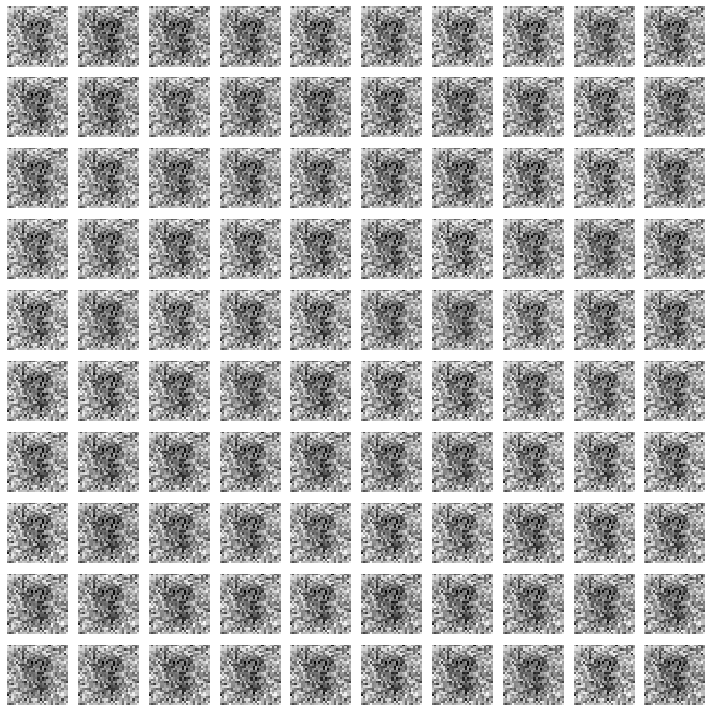

  0%|          | 0/234 [00:00<?, ?it/s]

--------------- Epoch 2 ---------------


100%|██████████| 234/234 [01:00<00:00,  3.90it/s]


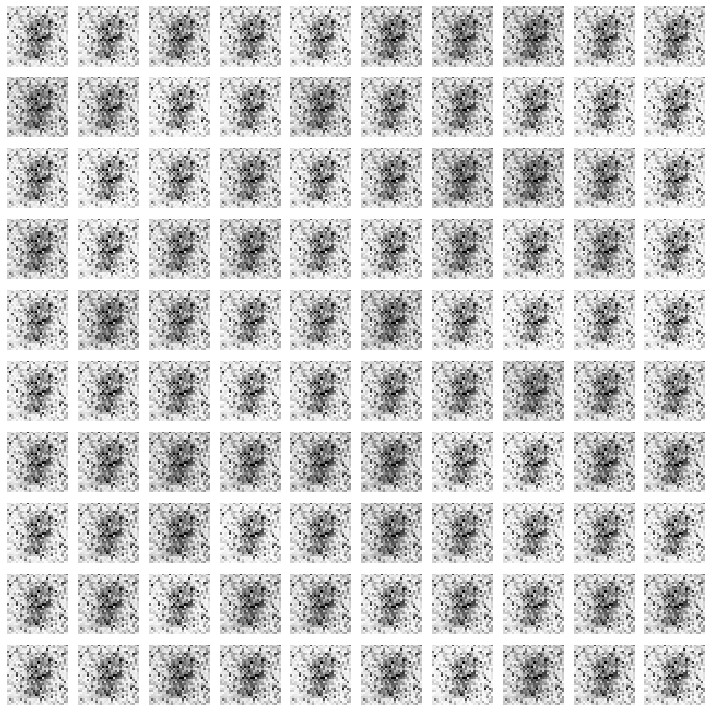

  0%|          | 0/234 [00:00<?, ?it/s]

--------------- Epoch 3 ---------------


100%|██████████| 234/234 [01:00<00:00,  3.87it/s]


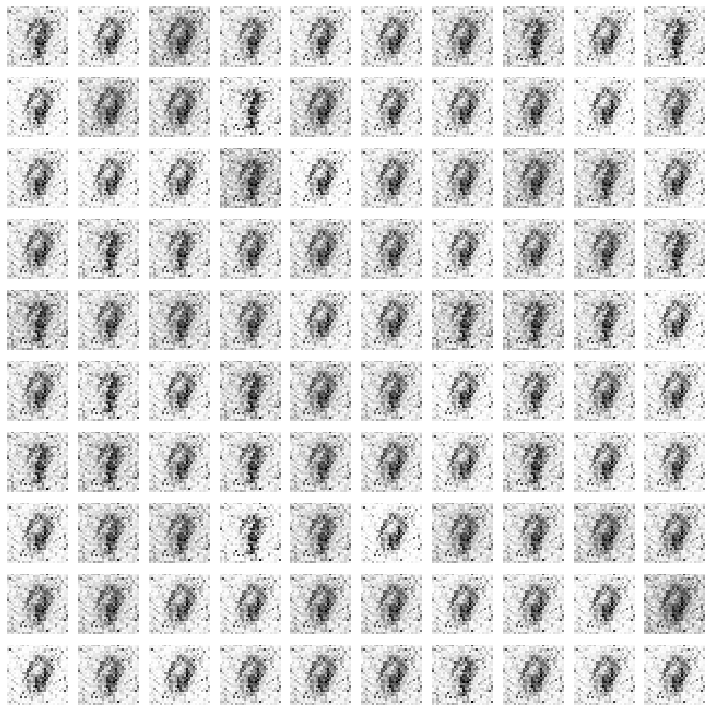

  0%|          | 0/234 [00:00<?, ?it/s]

--------------- Epoch 4 ---------------


100%|██████████| 234/234 [00:59<00:00,  3.91it/s]


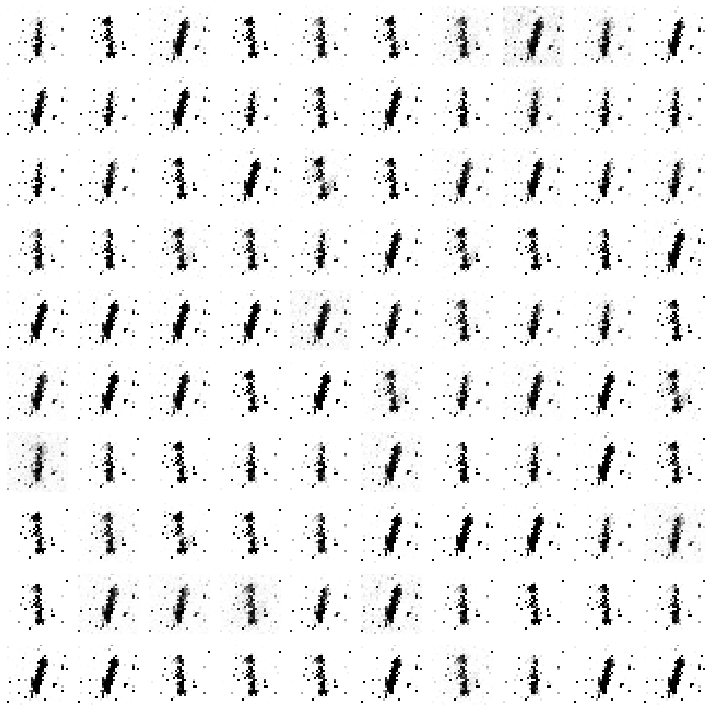

  0%|          | 0/234 [00:00<?, ?it/s]

--------------- Epoch 5 ---------------


100%|██████████| 234/234 [01:00<00:00,  3.88it/s]


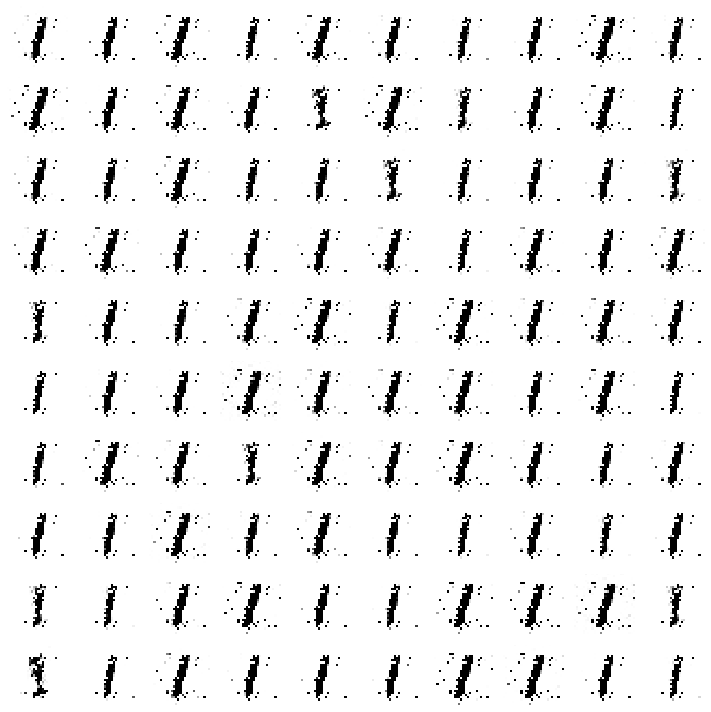

  0%|          | 0/234 [00:00<?, ?it/s]

--------------- Epoch 6 ---------------


 52%|█████▏    | 121/234 [00:31<00:29,  3.88it/s]

In [ ]:
    train(epochs=500, batch_size=256)